In [20]:
import IPython.display as ipd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import pymc as pm
from pymc_bart import BART
import arviz as az


In [5]:
# Load your data
df = pd.read_csv("data/training_dataset.csv")  # Replace with your actual filename

# Define features and target
features = [
    'Distance', 'Surface_Dirt', 'Surface_Turf', 'AvgPastFinishPosition',
    'WinRate', 'DistanceSuitability', 'JockeyWinRate',
    'FieldStrength', 'SurfaceWinRate'
]
target = 'FinishPosition'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
with pm.Model() as bart_model:
    # Register shared data
    X_shared = pm.MutableData("X", X_train)
    y_shared = pm.MutableData("y", y_train)

    # BART prior
    mu = BART("mu", X=X_shared, Y=y_shared)

    # Noise term
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_shared)

    # Sample posterior
    trace = pm.sample(draws=4000,
                      tune=3000,
                      chains=10,
                      target_accept=0.95,
                      random_seed=42)

/home/alireza/Apps/miniconda3/envs/homa_bart/lib/python3.10/site-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


Output()

Sampling 10 chains for 3_000 tune and 4_000 draw iterations (30_000 + 40_000 draws total) took 442 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [7]:
with bart_model:
    pm.set_data({"X": X_test})
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["mu"], return_inferencedata=True
    )

Sampling: [mu]


Output()

In [8]:
pred_means = posterior_predictive.posterior_predictive["mu"].mean(dim=["chain", "draw"]).values
# Accuracy (rounded prediction)
rounded_preds = np.round(pred_means)
rounded_preds = np.clip(rounded_preds, y_test.min(), y_test.max())

# Then compare with true values
for i, (true, pred) in enumerate(zip(y_test.values, rounded_preds)):
    print(f"Sample {i}: True={true:.2f}, Predicted={pred:.2f}")

Sample 0: True=4.00, Predicted=5.00
Sample 1: True=3.00, Predicted=6.00
Sample 2: True=2.00, Predicted=5.00
Sample 3: True=9.00, Predicted=5.00
Sample 4: True=3.00, Predicted=4.00
Sample 5: True=12.00, Predicted=6.00
Sample 6: True=10.00, Predicted=6.00
Sample 7: True=6.00, Predicted=4.00
Sample 8: True=7.00, Predicted=4.00
Sample 9: True=10.00, Predicted=5.00
Sample 10: True=6.00, Predicted=7.00
Sample 11: True=3.00, Predicted=6.00
Sample 12: True=7.00, Predicted=4.00
Sample 13: True=4.00, Predicted=5.00
Sample 14: True=3.00, Predicted=4.00
Sample 15: True=1.00, Predicted=5.00
Sample 16: True=5.00, Predicted=4.00
Sample 17: True=7.00, Predicted=6.00
Sample 18: True=3.00, Predicted=6.00
Sample 19: True=7.00, Predicted=6.00
Sample 20: True=1.00, Predicted=4.00
Sample 21: True=7.00, Predicted=5.00
Sample 22: True=6.00, Predicted=5.00
Sample 23: True=1.00, Predicted=4.00
Sample 24: True=6.00, Predicted=5.00
Sample 25: True=9.00, Predicted=6.00
Sample 26: True=11.00, Predicted=6.00
Sample 

In [32]:
accuracy = (rounded_preds == y_test.values).mean()
print(f"Accuracy (exact match): {accuracy:.2%}")

ValueError: operands could not be broadcast together with shapes (36,) (294,) 

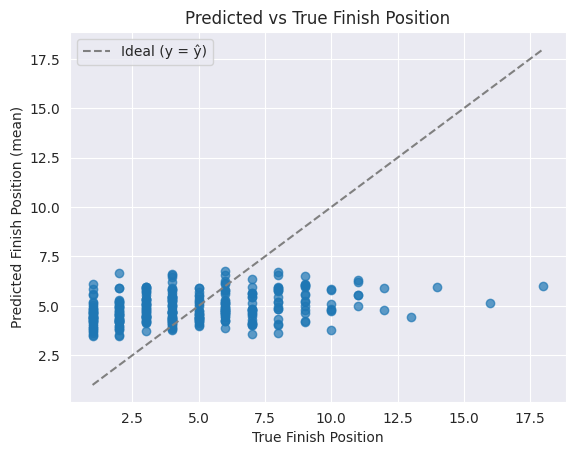

In [12]:
# Plot: True vs Predicted Finish Position
plt.scatter(y_test, pred_means, alpha=0.7)
plt.xlabel("True Finish Position")
plt.ylabel("Predicted Finish Position (mean)")
plt.title("Predicted vs True Finish Position")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    '--',
    color='gray',
    label='Ideal (y = ŷ)'
)
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

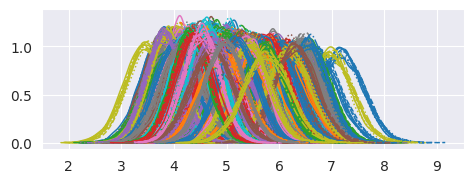

In [13]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Prediction

In [26]:
# Load your dataset
X_predict = pd.read_csv("data/CDX0426_processed_for_prediction.csv")  # Replace with your prediction dataset

race_number = [4, 5, 6, 7]
X_predict = X_predict[X_predict["RaceNumber"].isin(race_number)]

horse_names = X_predict["HorseName"]
race_ids = X_predict["RaceNumber"]
raceid_ids = X_predict["RaceID"]

features = [
    'Distance', 'Surface_Dirt', 'Surface_Turf', 'AvgPastFinishPosition',
    'WinRate', 'DistanceSuitability', 'JockeyWinRate',
    'FieldStrength', 'SurfaceWinRate'
]
X_predict = X_predict[features]

In [27]:
with bart_model:
    pm.set_data({"X": X_predict})
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["mu"], return_inferencedata=True
    )

Sampling: [mu]


Output()

In [29]:
# Extract posterior predictive draws
mu_draws = posterior_predictive.posterior_predictive["mu"]  # (chain, draw, horse)
mu_stacked = mu_draws.stack(sample=("chain", "draw"))       # (sample, horse)
mu_values = mu_stacked.transpose("sample", "mu_dim_0").values  # shape: (num_samples, num_horses)


In [30]:
from collections import defaultdict

# Map race IDs to list of indices (horses)
race_to_indices = defaultdict(list)
for idx, race in enumerate(raceid_ids):
    race_to_indices[race].append(idx)

# Compute first-place probabilities
first_place_probs = np.zeros(len(X_predict))

for race_id, indices in race_to_indices.items():
    race_draws = mu_values[:, indices]  # shape: (samples, horses)
    winners = np.argmin(race_draws, axis=1)

    for rel_idx, abs_idx in enumerate(indices):
        first_place_probs[abs_idx] = np.mean(winners == rel_idx)


In [31]:
results = pd.DataFrame({
    "HorseName": horse_names.values,
    "RaceNumber": race_ids.values,
    "RaceID": raceid_ids.values,
    "FirstPlaceProb": first_place_probs.round(4),
})

results = results.sort_values(by=["RaceID", "FirstPlaceProb"], ascending=[True, False])
ipd.display(results.groupby("RaceID").head(5).reset_index(drop=True))


,HorseName,RaceNumber,RaceID,FirstPlaceProb
0,SUNDANCE FEATURE,4,CD _20250426_4,0.6143
1,SAM'S TREASURE,4,CD _20250426_4,0.1747
2,LORD I WONDER,4,CD _20250426_4,0.0919
3,TWIRL AROUND,4,CD _20250426_4,0.0746
4,OUTRAGEOUSLY,4,CD _20250426_4,0.0423
5,SUCCESSION GOLD,5,CD _20250426_5,0.5706
6,PATROLMAN,5,CD _20250426_5,0.1386
7,FORGE IN FIRE,5,CD _20250426_5,0.1107
8,MUCHO MOJO,5,CD _20250426_5,0.0876
9,REDFIELD,5,CD _20250426_5,0.0531
